<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_SLAM_data_generation_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: SLAM Data Generation (v1)
This is the first notebook to really seriously look into generating realistic training data for the SLAM model.

This notebook follows on from `Experiment-SLAM-2.ipynb`.

**Focus for this notebook:**
* Generating more realistic LDS data with physically realistic noise.
* Getting agent and map locations more physically realistic.

**Problems identified in Experiment-SLAM-2:**

A number of problems with the data generation were identified there:
* Input maps are too complete and too perfect. They're exactly the same as the ground-truth maps, so there's nothing for the NN to do, and no incentive to use the LDS data to improve the map.
* The NN should always prefer the LDS data over its the input map, as the input map represents only a guess, while LDS is true state. I don't think I've got this balanced quite right in the training data yet.

**Suggestions from Experiment-SLAM-2:**

Some initial ideas for improving the training data were:
* Simulate an agent actually moving around an environment and building up the map from parts, instead of the current extremes: being given either a fully-known map or no-map in between.
  * Imagine taking a path along the map.
  * At each location collect what it can see within the LDS range - this collects a circle of data.
  * Then add some noise the LDS data before turning it into the input map.
  * Later on optionally add motion-skew (where the agent continuously slowly slides slightly to one side so that the SLAM map ends up over a curve and the NN will have to correct that).
  * API note: add collection of options for turning different kinds of errors on/off.
* Play around with occlusions more. Instead of being given a full map for the current location it should be given only a partial map, forcing it to do a partial-match on the map and the LDS data. eg:
  * Randomly drop half of the input map, centred on the map centre, according to a dividing line that goes through the centre at some random angle.
  * Use ~1/3rd sized circles of LDS range and randomly splat them around the map filling in only the parts that are splatted. Do this to build up the input map that is then snapshotted. Take a random number of splats, to simulate different levels of known map. Could be easy to implement by first building up mask from the splats and then applying that against the full map.

In [1]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
!cd repo && git checkout 49c0dc5
#!cd repo && git pull

import sys
sys.path.append('repo')

from general_utils import display_history
import lds
import slam
import slam_data
from importlib import reload
reload(lds)
reload(slam)
reload(slam_data)

Cloning into 'repo'...
remote: Enumerating objects: 336, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 336 (delta 124), reused 111 (delta 66), pack-reused 130 (from 1)
Receiving objects: 100% (336/336), 19.62 MiB | 8.30 MiB/s, done.
Resolving deltas: 100% (162/162), done.
Already up to date.


<module 'slam_data' from '/content/repo/slam_data.py'>

In [2]:
!pip install -Uqq ipdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import io
import os
import shutil
import tarfile
import cv2
import requests
import math
import ipdb
import tqdm
import time
from timeit import default_timer as timer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.0 MB/s eta 0:00:00


In [3]:
a = np.array([[0, 50, 0.5], [50, 100, 0.75], [20, None, 0.8]])
r = np.array([2, 20, 40, 50, 60, 70, 80, 90, 100, 120, 150, np.nan])
for start, end, stddev in a:
  print(f"{start} - {end} @ {stddev}")
  mask = (r >= start) & (end is None or r < end)
  noise = np.random.normal(0.0, 1.0, size=r.shape) * r
  #ranges[mask] += noise[mask]
  print(r[mask])
  print(noise[mask])



0 - 50 @ 0.5
[ 2. 20. 40.]
[  0.2784638  -27.45902129  15.41598757]
50 - 100 @ 0.75
[50. 60. 70. 80. 90.]
[-42.676249    11.30650089 -52.81845525 -68.06518826  15.18114042]
20 - None @ 0.8
[ 20.  40.  50.  60.  70.  80.  90. 100. 120. 150.]
[ -26.05479599   14.12110811   11.16293051   76.78975858  -28.58535868
  -13.05563285   30.74570275 -118.34519473  109.89416047 -237.84696378]


## LDS sampling with noise

In [4]:
floorplan = Image.open('repo/data/experimental-floorplan2.png')
floorplan = np.array(floorplan, dtype=np.uint8)
print(f"RGB encoded:     shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")

floorplan = slam_data.one_hot_encode_floorplan(floorplan).numpy()
print(f"one-hot encoded: shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")


RGB encoded:     shape=(139, 294, 3), dtype=uint8, value range: 0 - 255
one-hot encoded: shape=(139, 294, 3), dtype=float32, value range: 0.0 - 1.0


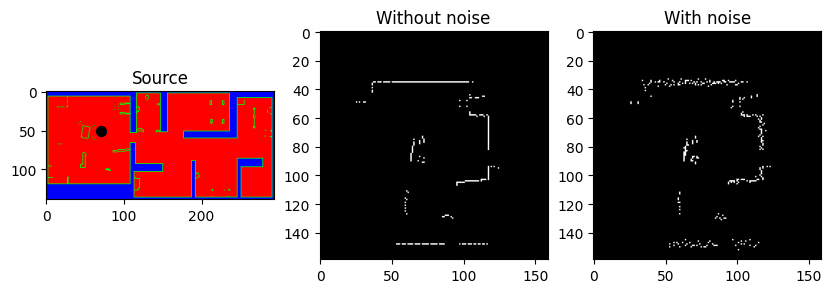

In [5]:
reload(lds)
loc = (70.0, 50.0)
ranges1 = lds.lds_sample(floorplan[:,:,1], np.array(loc) * lds.__PIXEL_SIZE__, angle=0.0, noise_ranges=None)
lds_points1 = lds.lds_to_occupancy_map(ranges1, angle=0.0)

ranges2 = lds.lds_sample(floorplan[:,:,1], np.array(loc) * lds.__PIXEL_SIZE__, angle=0.0)
lds_points2 = lds.lds_to_occupancy_map(ranges2, angle=0.0)

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.title('Source')
plt.imshow(floorplan)
plt.scatter(loc[0], loc[1], c='k', s=50)

plt.subplot(1,3,2)
plt.title("Without noise")
plt.imshow(lds_points1, cmap='gray')

plt.subplot(1,3,3)
plt.title("With noise")
plt.imshow(lds_points2, cmap='gray')

plt.show()



Generating 5 samples of training data
Pixel size: 44.71
Max distance: 3500
Sample types: [2]


100%|██████████| 5/5 [00:01<00:00,  3.76it/s]


Generated 5 samples after 5 attempts
Dataset tests passed (5 entries verified)
map_window:       (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.          0.04488318 -0.0763452   0.29178823]


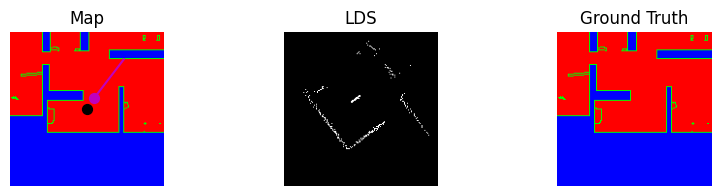

map_window:       (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.          0.3151994  -0.28233716  0.94763739]


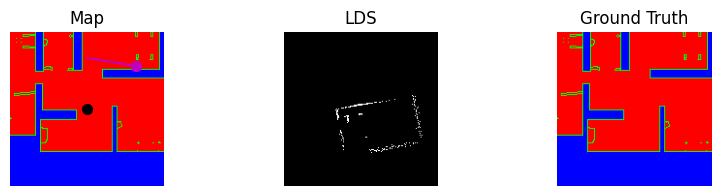

map_window:       (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.         -0.21482507 -0.14407245 -0.37053446]


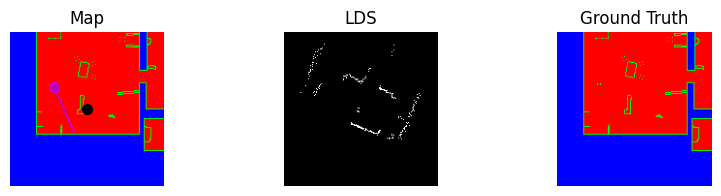

map_window:       (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.         -0.31369648  0.47986412  0.73457215]


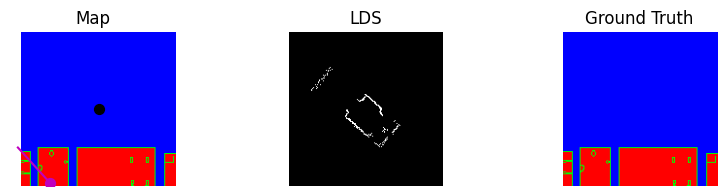

map_window:       (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.         -0.10941691 -0.4066159  -0.55908974]


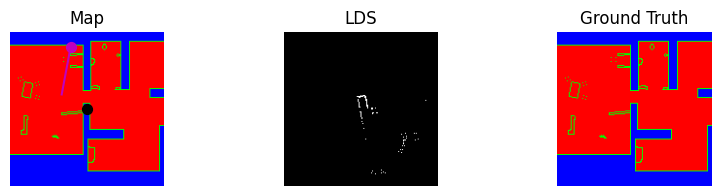

In [12]:
reload(lds)
reload(slam_data)
np.random.seed(0)
dataset = slam_data.generate_training_data(floorplan, 5, sample_types=(2))
slam_data.validate_dataset(dataset)
slam_data.show_dataset(dataset)

## Next Steps

Using model to generate input maps:
* Next step is to start using the model to generate the input map in the training data set.
* Probably split out the training into aeons.
During the first aeon it'll use ground-truth generated input maps.
At the end of each aeon it'll generate new input maps for the dataset and use them in the next aeon.

Improve code:
* The slam_data `generate_training_data_sample` function is a little bit of a mess now. The API I threw together in haste is counter to the way I'm now using it. So that nedes cleaning up.